# WorldCover 2020 vs 2021

In this notebook we are going to use the STAC API to load data for two different AOIs and compare the 2020 and 2021 maps.


## Toshka Lakes

The first AOI that we are going to analyze highlights change in water cover over the [Toshka Lakes (Egypt)](https://en.wikipedia.org/wiki/Toshka_Lakes) area. Toshka lakes are a set of endorheic lakes in the Sahara Desert of Egypt. The lakes formed in the years following the construction of the Aswan High Dam (1968). They take their name after the Toshka village, which was drowned after the construction of the dam.
The water level in the lakes varies across the years. We observe here a significant change between 2020 and 2021, with water covering a larger area in 2021.


### Data Loading

We demonstrated how to use the STAC catalogue to query products in the first notebook. Here we will just import a utility function from `utils/stac.py`

In [1]:
import os
from rio_tiler.io import STACReader

from utils.stac import query_products

def load_map(bounds, year, decimation_factor=None):
    products = query_products(aois[loc], year=year)

    # there is only one tile covering the area
    item = products[0]
    
    # this is to tell GDAL we do not need authentication
    os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

    # name of the map asset
    asset = 'ESA_WORLDCOVER_10M_MAP'
    print(item.assets[asset].href)
    with STACReader(None, item=item) as stac:
        img = stac.part(bounds, assets=asset)
    
    if decimation_factor is None:
        return img.data[0]
    else:
        return img.data[0][::decimation_factor, ::decimation_factor]


# bounds for the areas that we will visualize
aois = {'jackson': [-90.783, 33.176, -90.593, 33.368],
        'toshka':  [30.2, 23, 31, 23.8]}
years = [2020, 2021]

In [2]:
loc = 'toshka'
maps = {year: load_map(aois[loc], year, decimation_factor=3) for year in years}

s3://esa-worldcover/v100/2020/map/ESA_WorldCover_10m_2020_v100_N21E030_Map.tif
s3://esa-worldcover/v200/2021/map/ESA_WorldCover_10m_2021_v200_N21E030_Map.tif


### Visualize

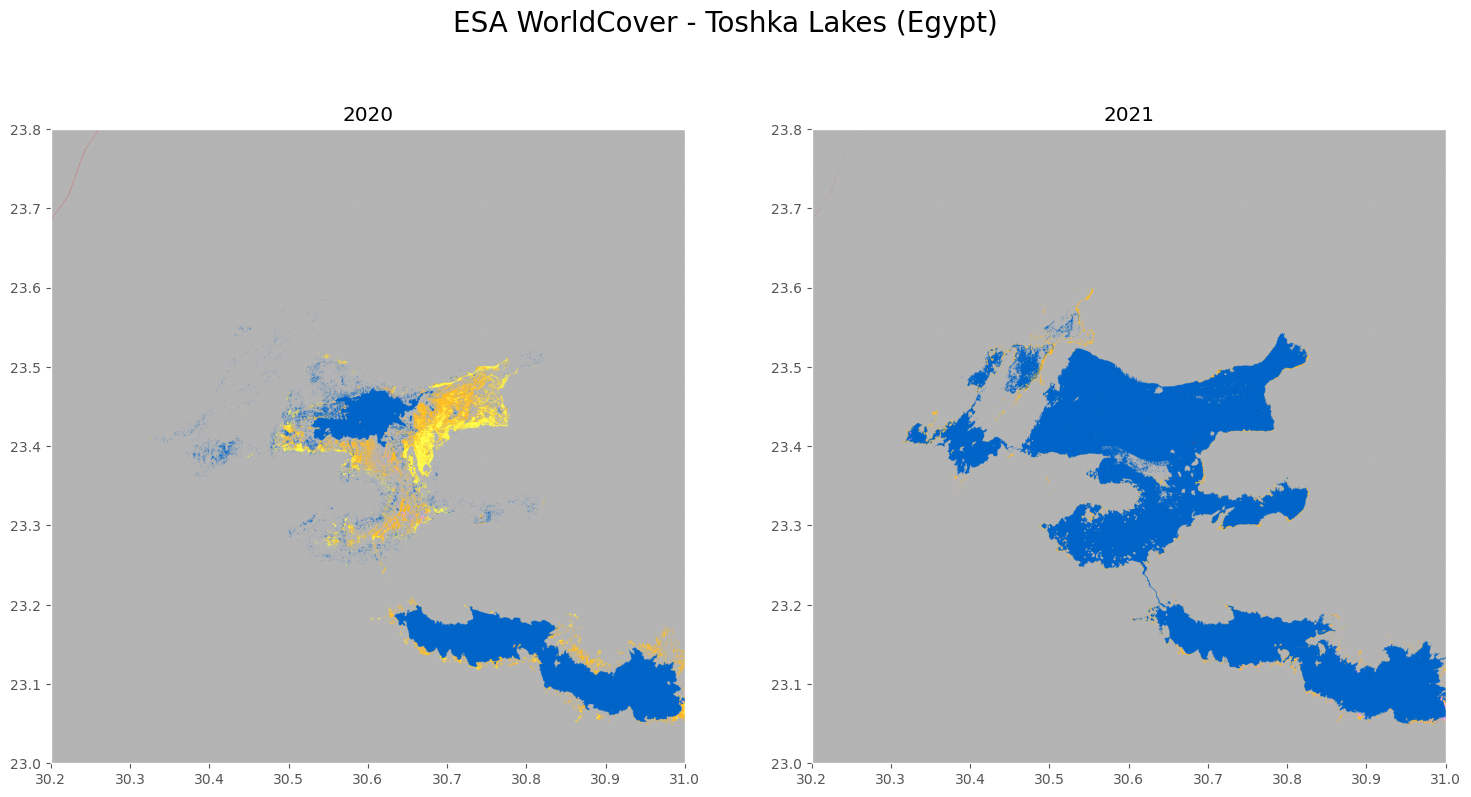

In [3]:
from utils.labels import label_to_rgb, legend_dict

import matplotlib.pyplot as plt
from matplotlib import style

# Show a bar plot illustrating the representation of land cover classes in the area of interest
style.use('ggplot')

# Convert the label rasters into RGB images (decimate the rgb raster for faster plotting)
rgb = {year: label_to_rgb(maps[year]) for year in years}


fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(18, 9))

xmin, ymin, xmax, ymax = aois[loc]
extent = (xmin, xmax, ymin, ymax)
for ax, year in zip(axs, years):
    ax.imshow(rgb[year], extent=extent)
    ax.set_title(f'{year}')
    ax.grid(False)

_ = plt.suptitle('ESA WorldCover - Toshka Lakes (Egypt)', fontsize=20)

### WMS Composites

We are now going to use the Terrascope WMS service to load the S2 RGB yearly median composite of the same area and years, in order to verify visually the change.

In [4]:
import numpy as np
from rasterio import MemoryFile
from rasterio.plot import show
from urllib.request import urlopen
from rasterio.warp import transform_bounds


def load_wms(bounds, year, layer, width=None, height=None):

    xmin, ymin, xmax, ymax = transform_bounds('EPSG:4326', 'EPSG:3857', *bounds)
    
    url = ('https://services.terrascope.be/wms/v2?service=WMS&version=1.3.0&request=GetMap&layers='
           f'WORLDCOVER_{year}_{layer}&format=image/png&time={year}-01-01&width={width}&height={height}'
           f'&bbox={xmin},{ymin},{xmax},{ymax}&styles=&srs=EPSG:3857')
    print(url)
    tif_bytes = urlopen(url).read()

    with MemoryFile(tif_bytes) as memfile:
         with memfile.open() as dataset:
                return dataset.read()

            
width, height = 1600, 1600

layer = 'S2_TCC'
s2_tcc = {year: load_wms(aois[loc], year, layer, width, height)
          for year in years}

https://services.terrascope.be/wms/v2?service=WMS&version=1.3.0&request=GetMap&layers=WORLDCOVER_2020_S2_TCC&format=image/png&time=2020-01-01&width=1600&height=1600&bbox=3361848.6219568616,2632018.6375864246,3450904.2145914803,2729056.1076330794&styles=&srs=EPSG:3857


/home/daniele/miniconda3/lib/python3.9/site-packages/rasterio/io.py:138: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  return DatasetReader(mempath, driver=driver, sharing=sharing, **kwargs)


https://services.terrascope.be/wms/v2?service=WMS&version=1.3.0&request=GetMap&layers=WORLDCOVER_2021_S2_TCC&format=image/png&time=2021-01-01&width=1600&height=1600&bbox=3361848.6219568616,2632018.6375864246,3450904.2145914803,2729056.1076330794&styles=&srs=EPSG:3857


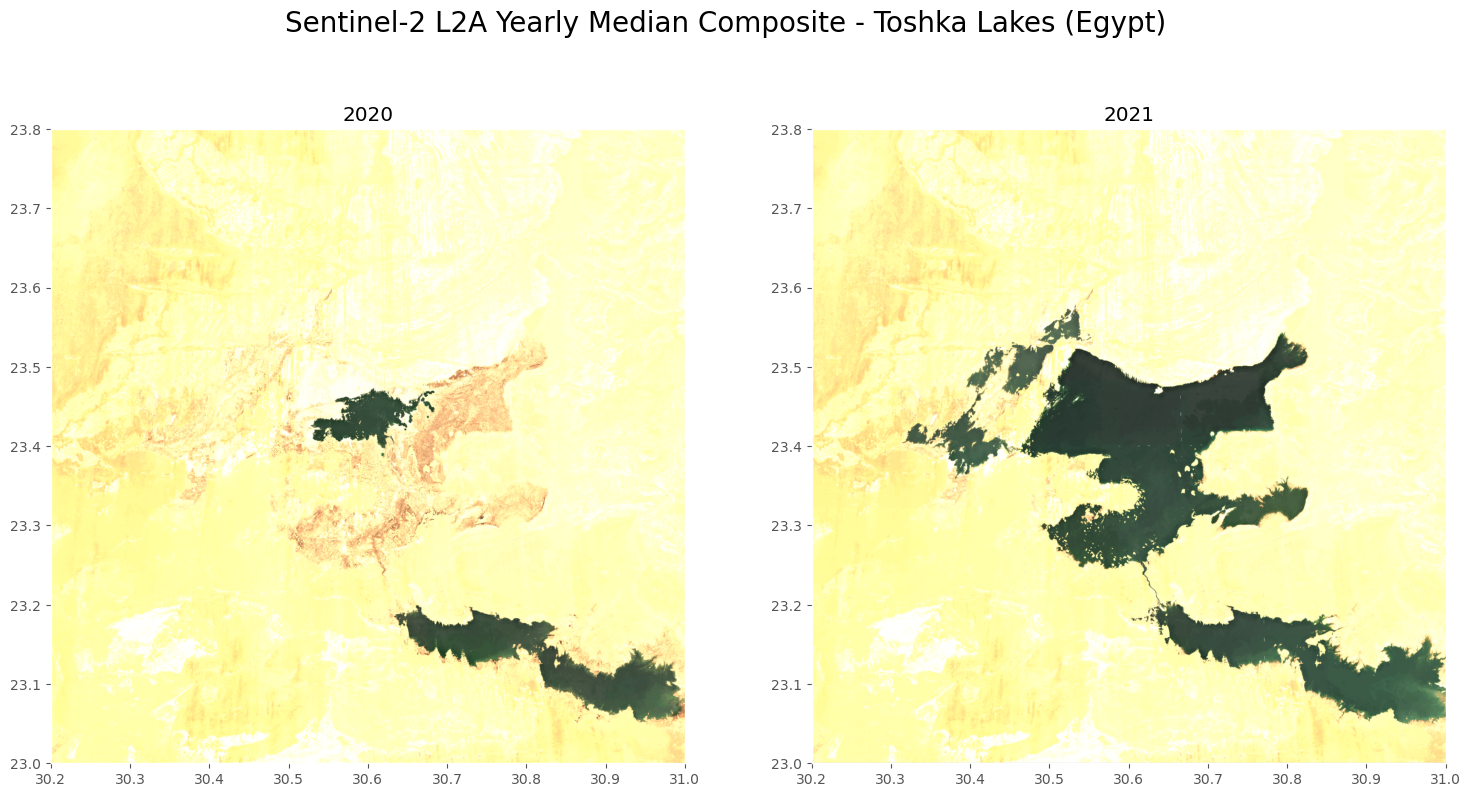

In [5]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(18, 9))

xmin, ymin, xmax, ymax = aois[loc]
extent = (xmin, xmax, ymin, ymax)
for ax, year in zip(axs, years):
    ax.imshow(np.moveaxis(s2_tcc[year], 0, 2), extent=extent)
    ax.set_title(f'{year}')
    ax.grid(False)

_ = plt.suptitle('Sentinel-2 L2A Yearly Median Composite - Toshka Lakes (Egypt)', fontsize=20)

### Water change map

In [6]:
import enum

import numpy as np


class WaterColors(enum.Enum):

    NO_DATA = (0, 'background',
               np.array([210, 210, 210]) / 255)
    
    WATER2020 = (1, 'water_2020',
                 np.array([0, 100, 200]) / 255)

    WATER_EXP = (2, 'water_exp',
                 np.array([135, 211, 255]) / 255)

    WATER_RETR = (3, 'water_retr',
                 np.array([255, 148, 148]) / 255)
    
    def __init__(self, val1, val2, val3):
        self.id = val1
        self.class_name = val2
        self.color = val3

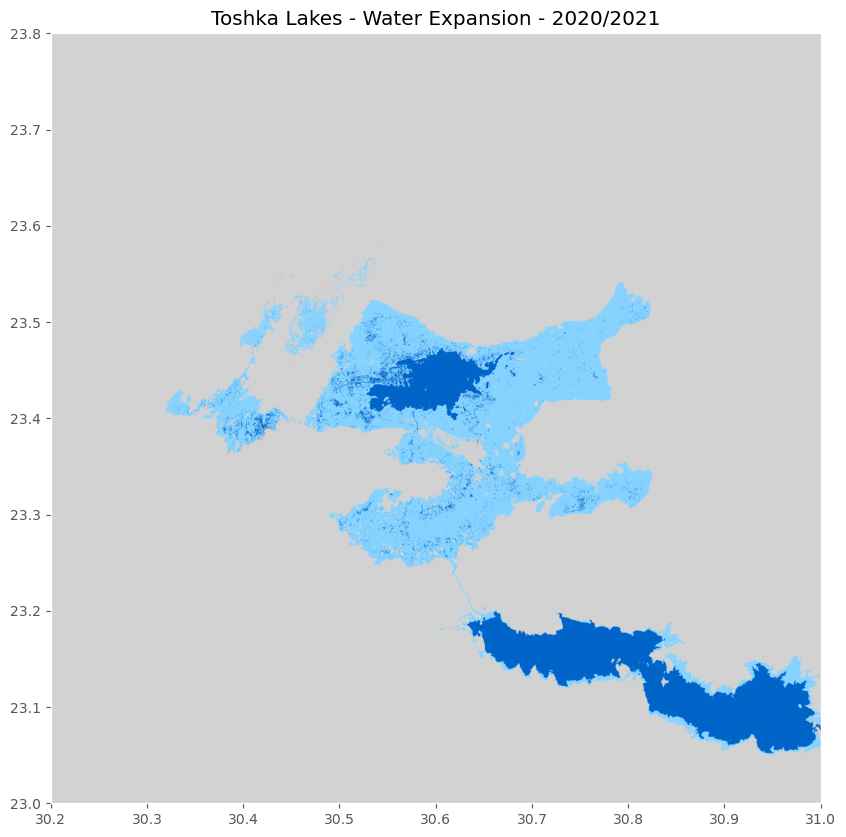

In [7]:
change = np.zeros_like(maps[2020])

change[maps[2020] == 80] = 1
change[(maps[2020] != 80) & (maps[2021] == 80)] = 2
change[(maps[2020] == 80) & (maps[2021] != 80)] = 3

water_rgb = label_to_rgb(change, WaterColors)

fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(water_rgb, extent=extent)
ax.set_title(f'Toshka Lakes - Water Expansion - 2020/2021')
ax.grid(False)


In [8]:
import numpy as np

# Count water pixels to compute relative water expansion
water_pixels = {}
for year in years:
    vals, counts = np.unique(maps[year], return_counts=True)
    water_pixels[year] = counts[vals.tolist().index(80)]
    

In [9]:
water_pixels_rel = water_pixels[2020] / water_pixels[2021]

In [10]:
water_pixels_rel

0.33777183767771063

For the area of interest, we see that for year 2021 we have water coverage 3 times larger compared to 2020.

## Second Example - Classification Improvements

For the 2021 map development, ESA required an improvement of the classification accuracy. As a consequence, not all changes observed in the maps are pure land cover changes and can also be due to the improvement of the retrieval algorithm which fixes issues we observed in the 2020 map.

In this second example we will focus on such a case, an area just above Jackson, Missisipi (US), where the observed change between the 2 years is due to the improvement of the classification.



In [11]:
loc = 'jackson'
maps = {year: load_map(aois[loc], year, decimation_factor=None) for year in years}

s3://esa-worldcover/v100/2020/map/ESA_WorldCover_10m_2020_v100_N33W093_Map.tif
s3://esa-worldcover/v200/2021/map/ESA_WorldCover_10m_2021_v200_N33W093_Map.tif


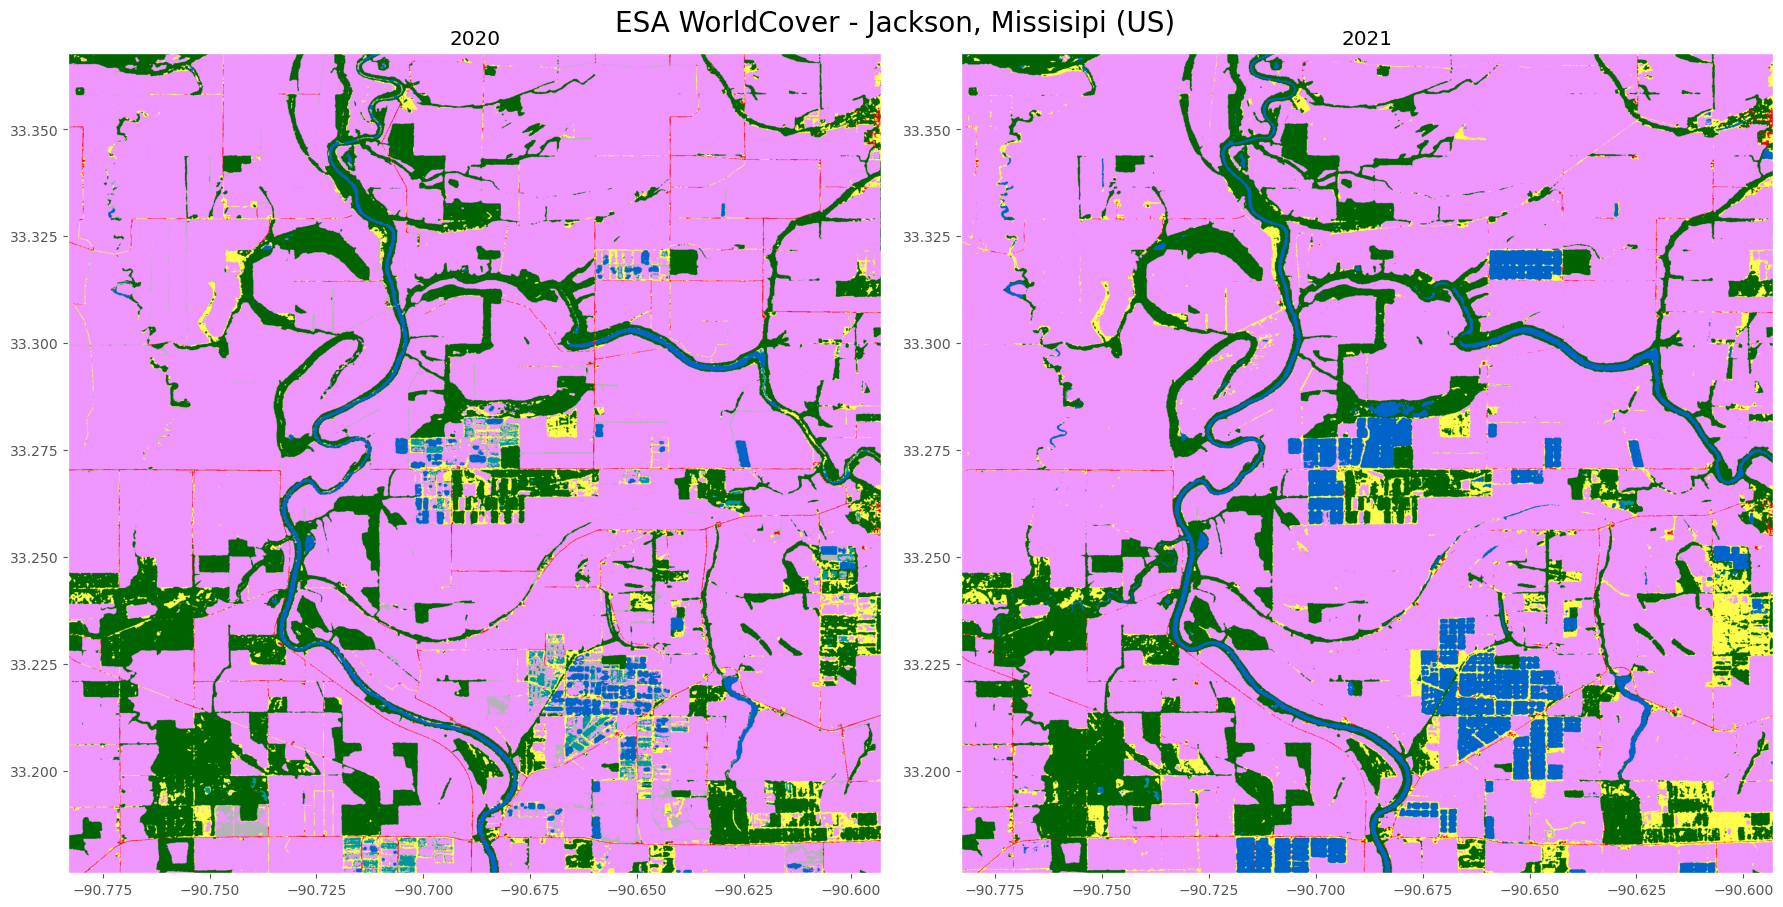

In [12]:
from utils.labels import label_to_rgb, legend_dict

import matplotlib.pyplot as plt
from matplotlib import style

# Convert the label rasters into RGB images (decimate the rgb raster for faster plotting)
rgb = {year: label_to_rgb(maps[year]) for year in years}


fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(18, 9))

xmin, ymin, xmax, ymax = aois[loc]
extent = (xmin, xmax, ymin, ymax)
for ax, year in zip(axs, years):
    ax.imshow(rgb[year], extent=extent)
    ax.set_title(f'{year}')
    ax.grid(False)

_ = plt.suptitle('ESA WorldCover - Jackson, Missisipi (US)', fontsize=20)
plt.tight_layout()

We can observe that part of these artificial lakes were not classified properly in 2020.

Checking the S1 GAMMA0 yearly median composite, confirms that the lakes were water cover also in 2020.

In [13]:
layer = 'S1_VVVHratio'
s1_gamma0 = {year: load_wms(aois[loc], year, layer, width, height)
             for year in years}

https://services.terrascope.be/wms/v2?service=WMS&version=1.3.0&request=GetMap&layers=WORLDCOVER_2020_S1_VVVHratio&format=image/png&time=2020-01-01&width=1600&height=1600&bbox=-10105917.332685756,3918688.388336465,-10084766.629435033,3944252.2987609245&styles=&srs=EPSG:3857
https://services.terrascope.be/wms/v2?service=WMS&version=1.3.0&request=GetMap&layers=WORLDCOVER_2021_S1_VVVHratio&format=image/png&time=2021-01-01&width=1600&height=1600&bbox=-10105917.332685756,3918688.388336465,-10084766.629435033,3944252.2987609245&styles=&srs=EPSG:3857


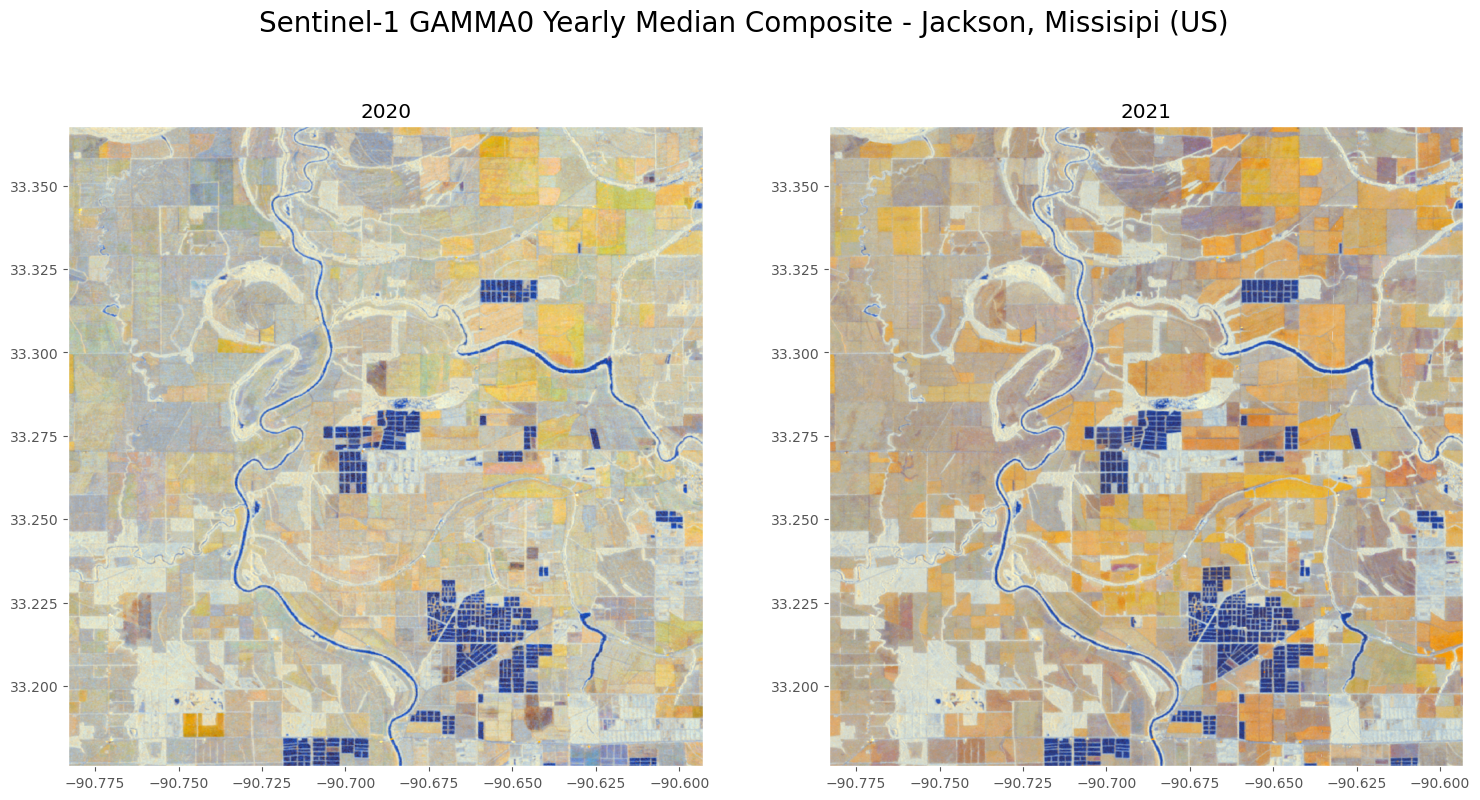

In [14]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(18, 9))

xmin, ymin, xmax, ymax = aois[loc]
extent = (xmin, xmax, ymin, ymax)
for ax, year in zip(axs, years):
    ax.imshow(np.moveaxis(s1_gamma0[year], 0, 2), extent=extent)
    ax.set_title(f'{year}')
    ax.grid(False)

_ = plt.suptitle('Sentinel-1 GAMMA0 Yearly Median Composite - Jackson, Missisipi (US)', fontsize=20)


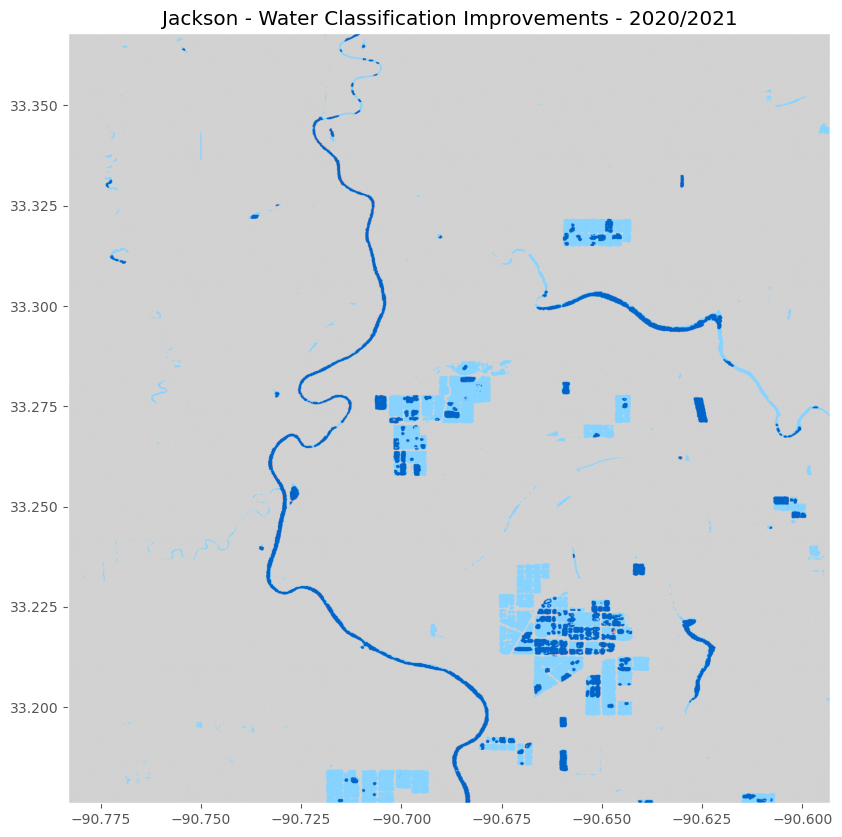

In [15]:
change = np.zeros_like(maps[2020])

change[maps[2020] == 80] = 1
change[(maps[2020] != 80) & (maps[2021] == 80)] = 2
change[(maps[2020] == 80) & (maps[2021] != 80)] = 3

water_rgb = label_to_rgb(change, WaterColors)

fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(water_rgb, extent=extent)
ax.set_title(f'Jackson - Water Classification Improvements - 2020/2021')
ax.grid(False)

In this case the change map shows the improved classification of water bodies, including smaller lakes and rivers.